#### Library Dependencies

In [1]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
import yfinance as yf

import matplotlib.pyplot as plt

#### Import Data Structure

In [2]:
# Data Import
start_date = "2017-01-1"
end_date = "2022-06-1"
symbol = "ES=F"
data = yf.download(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


#### Feature Engineering

In [3]:
# Returns and Volatility Features 
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Volatility"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
print("Length: ", len(df))
df.head()

Length:  1362


,Open,High,Low,Close,Adj Close,Volume,Returns,Volatility
Date,,,,,,,,
2017-01-04 00:00:00-05:00,2252.75,2267.25,2251.00,2264.25,2264.25,1404875,0.005216,0.007219
2017-01-05 00:00:00-05:00,2264.50,2266.00,2254.00,2264.25,2264.25,1324035,0.000000,0.005324
2017-01-06 00:00:00-05:00,2264.25,2277.00,2258.25,2271.50,2271.50,1551007,0.003202,0.008303
2017-01-09 00:00:00-05:00,2271.25,2275.25,2263.50,2265.00,2265.00,1025182,-0.002862,0.005191
2017-01-10 00:00:00-05:00,2264.50,2274.00,2259.50,2263.75,2263.75,1304523,-0.000552,0.006417


In [4]:
# Moving Average Features
df["MA_9"] = df["Adj Close"].rolling(window=9).mean()
df["MA_21"] = df["Adj Close"].rolling(window=21).mean()

#### Training and Test Data

In [5]:
# Structure Data for Training and Testing
X_train = df[["Returns", "Volatility"]].iloc[:500] 
X_test = df[["Returns", "Volatility"]].iloc[500:] 
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  862
X_train From:  2017-01-04 00:00:00-05:00
X_train To:  2018-12-28 00:00:00-05:00
X_test From:  2018-12-31 00:00:00-05:00
X_test To:  2022-05-31 00:00:00-04:00


#### Hidden Markov Model Statistical Learning

In [6]:
# HMM Training
hmm_model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
hmm_model.train([np.array(X_train.values)])
hmm_model.predict([X_train.values])[0][:10]

array([0, 0, 0, 3, 3, 0, 3, 0, 3, 0])

In [7]:
# Test Data Prediction 
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = hmm_model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Close,Adj Close,Volume,Returns,Volatility,MA_9,MA_21,HMM
Date,,,,,,,,,
2018-12-31 00:00:00-05:00,2495.50,2505.25,2505.25,1414594,0.007743,0.012184,2476.833333,2588.107143,0
2019-01-02 00:00:00-05:00,2508.00,2511.00,2511.00,1969697,0.002295,0.028137,2474.083333,2577.000000,2
2019-01-03 00:00:00-05:00,2482.25,2447.75,2447.75,2257341,-0.025189,0.020567,2467.916667,2562.214286,1
2019-01-04 00:00:00-05:00,2451.75,2531.25,2531.25,2350836,0.034113,0.041316,2472.972222,2549.857143,2
2019-01-07 00:00:00-05:00,2537.25,2550.50,2550.50,1632131,0.007605,0.017537,2482.166667,2542.654762,3


#### Systematic Strategy Backtesting

In [8]:
# Moving Average Signals
df_main.loc[df_main["MA_9"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_9"] <= df_main["MA_21"], "MA_Signal"] = 0

In [9]:
# Hidden Markov Model Signals
favorable_states = [0, 1]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favorable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [10]:
# Signal Combination
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [11]:
# Benchmark Returns
df_main["benchmark_log_return"] = np.log(df_main["Adj Close"] / df_main["Adj Close"].shift(1))
df_main["benchmark_cumulative"] = df_main["benchmark_log_return"].cumsum()
df_main["benchmark_cumulative_expo"] = np.exp(df_main["benchmark_cumulative"]) - 1

In [12]:
# Strategy Returns
df_main["strategy_log_return"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["strategy_cumulative"] = df_main["strategy_log_return"].cumsum()
df_main["strategy_cumulative_expo"] = np.exp(df_main["strategy_cumulative"]) - 1

In [13]:
# Examine Results
df_main.dropna(inplace=True)
df_main.tail()

,Open,Close,Adj Close,Volume,Returns,Volatility,MA_9,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,benchmark_log_return,benchmark_cumulative,benchmark_cumulative_expo,strategy_log_return,strategy_cumulative,strategy_cumulative_expo
Date,,,,,,,,,,,,,,,,,,
2022-05-23 00:00:00-04:00,3910.50,3971.75,3971.75,1736162,0.018528,0.019391,3962.055556,4075.023810,1,0.0,1,0.0,0.018358,0.460818,0.585371,0.0,0.079396,0.082633
2022-05-24 00:00:00-04:00,3951.75,3940.50,3940.50,2017453,-0.007868,0.021307,3963.194444,4058.250000,2,0.0,0,0.0,-0.007899,0.452919,0.572897,-0.0,0.079396,0.082633
2022-05-25 00:00:00-04:00,3950.00,3976.75,3976.75,1744116,0.009199,0.021528,3968.694444,4049.023810,1,0.0,1,0.0,0.009157,0.462076,0.587367,0.0,0.079396,0.082633
2022-05-26 00:00:00-04:00,3972.25,4055.75,4055.75,1493132,0.019865,0.028532,3972.694444,4043.095238,2,0.0,0,0.0,0.019671,0.481747,0.618900,0.0,0.079396,0.082633
2022-05-27 00:00:00-04:00,4047.50,4155.75,4155.75,1547507,0.024656,0.031426,3989.472222,4037.011905,1,0.0,1,0.0,0.024357,0.506104,0.658816,0.0,0.079396,0.082633


#### Systematic Strategy Metrics

In [14]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [15]:
# Benchmark Metrics
benchmark_return = round(df_main["benchmark_cumulative_expo"].values[-1] * 100, 1)
benchmark_sharpe = sharpe_ratio(df_main["benchmark_log_return"].values)

# Strategy Metrics
strategy_return = round(df_main["strategy_cumulative_expo"].values[-1] * 100, 1)
strategy_sharpe = sharpe_ratio(df_main["strategy_log_return"].values)

In [16]:
# Print Metrics
print(f"Benchmark Returns: {benchmark_return}%")
print(f"Benchmark Sharpe: {benchmark_sharpe}")
print("--------------------------")
print(f"Strategy Returns: {strategy_return}%")
print(f"Strategy Sharpe: {strategy_sharpe}")

Benchmark Returns: 65.9%
Benchmark Sharpe: 0.62
--------------------------
Strategy Returns: 8.3%
Strategy Sharpe: 0.16


#### Systematic Strategy Performance Inference

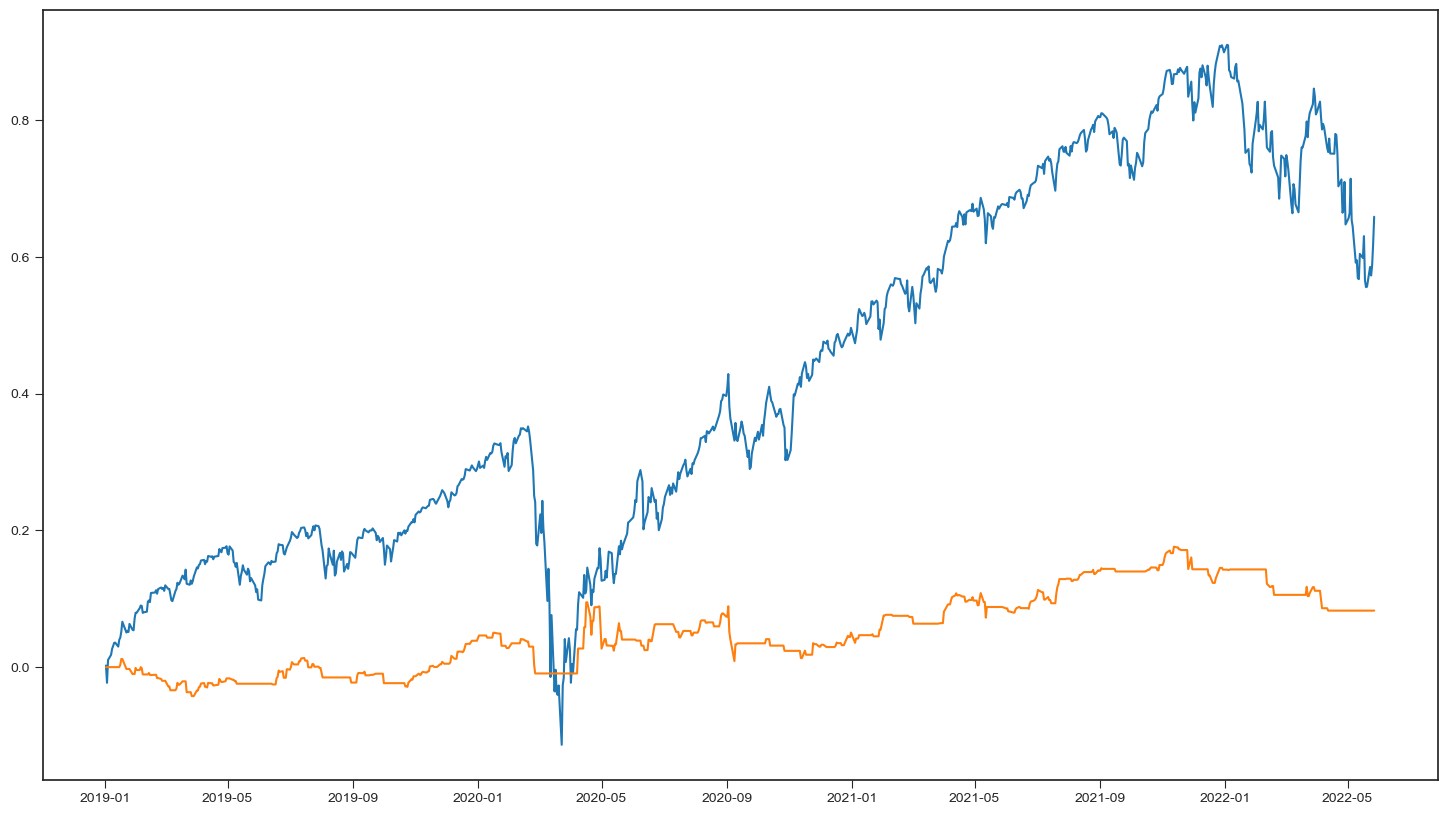

In [17]:
# Equity Curve 
fig = plt.figure(figsize = (18, 10))
plt.plot(df_main["benchmark_cumulative_expo"])
plt.plot(df_main["strategy_cumulative_expo"])
plt.show()